# Lab 07 : Heat Flow

## Objectives

In this lab we will solve a system of linear equations to study heat flow in a rod and produce nice, color "heat maps" of the results using `imshow`.

Much of the preparation for this lab was discussed in the prelab. **You must understand and complete PreLab 07 to proceed!** In fact, once you have completed the prelab we can just apply those results to a couple of initial conditions.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

# For random numbers
rng = np.random.default_rng()

## Heat Flow

The prelab contains a more thorough discussion of how we will solve for the heat flow through a rod. Here we summarize the important points.

The temperature at position $x$ and time $t$, $T(t,x)$, satisfies the partial differential equation
$$ \frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}. $$
Using the *Crank-Nicolson* method it can be shown that this partial differential equation becomes the **system of linear equations**
$$
-r T(t_{j+1},x_{i-1}) + (1+2r) T(t_{j+1},x_i) - r T(t_{j+1},x_{i+1}) = r T(t_j,x_{i-1}) + (1-2r) T(t_j,x_i) +r T(t_j,x_{i+1}),
$$
where
$$ r\equiv \frac{\Delta t}{2(\Delta x)^2},$$
and $\Delta t$ and $\Delta x$ are the time and space step sizes. In the prelab we saw that this can be written in the form
$$ \mathsf{A}\vec T_{j+1} = \mathsf{B} \vec T_j \equiv \vec \tau_j, $$
where we know how to construct $\mathsf{A}$ and $\vec\tau_j$. Further, we discussed solving this system using `scipy.linalg.solve_banded`. We will apply this now.

(*Note:* As mentioned in the prelab, you can use `scipy.linalg.solveh_banded` instead of `scipy.linalg.solve_banded` if so inclined.)

Copy the useful results from the prelab. In particular, your functions for calculating $\vec\tau_j$ and the coefficient matrix should be included here.

In [ ]:
def tau(T, r):
    """
    Determine the right hand side of the system of equations given above to
      describing the temperature of a rod evolving in time. Since we set all
      values depending on x_{i-1} and x_{N+1} to zero, there are zeroes at 
      the beginning and end of our system we must consider, which we do by 
      shifting the array to the left and right, and filling in a zero. 
    Inputs:
      T: array: Vector of temperature at positions  along the rod at some time.
      r: float: Step size parameter in the Crank-Nicolson method.
    Outputs :
     tau: array (same shape as T): The right hand side of the system of equations.
     """
    
    #create an array shifted to the right where the first index is zero:
    shift_right=np.roll(T, 1)
    shift_right[0]=0
    #and an array shifted to the left where the last index is 0:
    shift_left=np.roll(T, -1)
    shift_left[-1]=0
    
    #all values are multiplied by (1-2r), but the outermost are not multiplied by r
    return (shift_right*r) + (T*(1-2*r)) + (shift_left*r)

def coefficient_matrix(N, r):
    """
    Construct the banded coefficient matrix (named A above) for the heat equation.
      A is an NxN tridiagonal matrix based on the passed value r (the step size used 
      the Crank-Nicholson method to solve the heat equation) and returned as a banded
      matrix which can be passed to  `scipy.linalg.solve_banded`.
    Inputs:
      N: integer: number of linear equations to solve
      r: float: step size parameter for the Crank-Nicolson method
    Outputs:
      ab: 2d array of size 3xN
    """
    #construct main diagonal of the A matrix  
    diag = np.full(N, 1+2*r)

    #construct upper diagonal 
    upper = np.full(N, -r)

    #construct the lower diagonal 
    lower=np.full(N, -r)

    #construct and return the matrix
    A=np.array([upper, diag, lower])
    return A

## Test Case

As has been stated a few times, whenever we solve a numerical problem we should first apply our technique to a problem with a known solution. It is easy to make simple mistakes and solving a known problem can catch many (but not necessarily all) such mistakes.

For our test problem we will solve for the temperature along a rod of length $L=1$ discretized by splitting it into $1000$ segments ($N_x=1001$ points). For the initial temperature profile we will let $T(0,x)=\sin(\pi x)$. To evolve the system choose $\Delta t=10^{-4}$ and evolve for $N_t=N_x$ steps. Evolve the system by solving the linear system of equations at each time step. (Since this is an iterative algorithm you *must* use a loop to step through time.) Store your results in a two dimensional array, `T[j,i]`, so that each *row* of the array is the temperature along the rod at a particular time.

For these initial conditions the known solution is $T(t,x) = \mathrm{e}^{-\pi^2 t} \sin(\pi x)$. We will use this to test our numerical solution.

Solve for the heat flow in the rod as a function of time, $T(t,x)$, using the method described above. Provide the code for doing this below.

Test your results! As you are working through the solution it is often useful to produce quick plots at various time steps showing your result and the known solution. You may include these plots in your notebook if you prefer, regardless, you should find good agreement (at least at the level of plots) between your solution and the known one. (A precise comparison is harder to make. The accuracy of the numerical solution depends on $r$, we would need to more carefully study the Crank-Nicolson method to know the expected accuracy.)

In [11]:
#define given parameters 
segments=1000
N=segments+1
L=1
del_x=L/segments
del_t=1e-4

#calculate r
r=del_t/(2*(del_x**2))

#create the array of initial temperatures along the rod
x=np.linspace(0,L,N)
init_T = np.sin(np.pi*x)

#confirm that this works
def true(t,x):
    return np.exp(-(np.pi**2)*t)*np.sin(np.pi*x)
tau0=tau(init_T, r)
step1=la.solve_banded((1,1), coefficient_matrix(N, r), tau0)
assert(np.allclose(step1, true(del_t, x), atol=6e-3)) # this tolerance seems reasonable

#create an array of times. done somewhat clunkily to be able to use linspace
#instead of arange, since linspace works better for the small numbers being used
#here.
end=.1
num=int(end/del_t) # likely not a generalizable method but it works here
times = np.linspace(0,end,num+1)

#create an array with as many rows as times being examined, where each row
#contains all the positions along the rod we are examining. fill the first
#row with the given initial condition, and iterate from there via finding 
#a new right side and A matrix and solving that system. this does recalculate
#the first step found above, but is usable without requiring that such a step
#is calculated. 
T=np.zeros((len(times), len(x)))
T[0]=init_T
for i in range(1,num+1):
    right_side=tau(T[i-1], r)
    T[i]=la.solve_banded((1,1), coefficient_matrix(N, r), right_side)

Produce a nice figure of your results showing the temperature along the rod at the times, $t=0$, $0.025$, $0.05$, $0.075$, and $0.1$.

Text(0.5, 1.0, 'Temperature vs Position of Rod Evolving in Time')

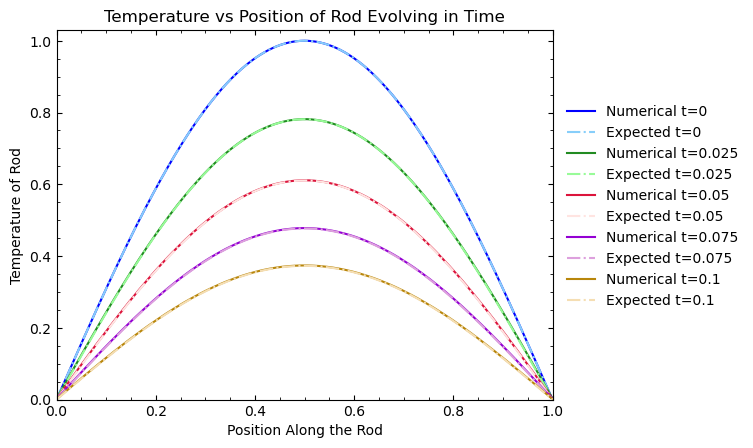

In [12]:
#times at which to plot the temperature, and colors of the numerical and expected solutions at those times
plot_times=[0, .025, .05, .075, .1]
colors=[('b', 'lightskyblue'), ('forestgreen', 'palegreen'), ('crimson', 'mistyrose'), ('darkviolet', 'plum'), ('darkgoldenrod', 'wheat')]
    
fig=plt.figure()
ax=fig.add_subplot(111)
def visual(i):
    '''
    Determine the array index of a given time, and plot the temperature at 
      that time against position using a solid line. Overplot a dash-dotted 
      line of the expected temperatures at that time. 
    Inputs: 
      i: int: an index of an array containing times to be plotted. 
    '''
    ix = np.where(times==plot_times[i])
    ax.plot(x, T[ix][0], c=colors[i][0], label=f'Numerical t={plot_times[i]}')
    ax.plot(x, true(plot_times[i], x), ls='-.', c=colors[i][1], label=f'Expected t={plot_times[i]}')

visual(0)
visual(1)
visual(2)
visual(3)
visual(4)

ax.set_xlim(0,1)
ax.set_ylim(0, 1.03)
fig.legend(bbox_to_anchor=(1.21, .75), frameon=False) #theres gotta be a neater way to do this
ax.set_xlabel('Position Along the Rod')
ax.set_ylabel('Temperature of Rod')
ax.set_title('Temperature vs Position of Rod Evolving in Time')

The above plot is nice, but it is even nicer to see the actual two dimensional heat flow (space and time). We can do this using `imshow`. Unfortunately `imshow` has some behavior we need to work around. It knows nothing about what the $x$ and $y$ axes represent so just uses index values. It also starts with $(0,0)$ in the upper left corner whereas for us it would make more sense to put it in the lower left corner (reverse the $y$-axis). We can fix these issues and make the plot much nicer by doing a few things. Here I will assume we use the usual variables `fig` and `ax` when we create a figure. Modify the function calls given below as need be.

1. As noted, our $y$-axis represents time and it makes more sense to have time increasing as we move upward. This behavior can easily be changed by switching the order of the limits on the $y$-axis. When you first use `imshow` if you check the limits using `ax.get_ylim()` what do you see? How do we change the limits along the $y$-axis? Alternatively the order of the input array can be reversed (at least for the $y$-axis). This is less elegant, but does work.
2. The use of index numbers for the axis tick labels is not very informative. We do have full control over ticks and their labels, but modifying them can become involved if we want a generic way of manipulating them. For our purposes if we just want to change the tick labels we can use `ax.set_xticks` and `ax.set_yticks`. Even with these there are some details to work out. Though it is much nicer to do so, it is **not required to fix the tick labels**. You may leave them as index values if you prefer.
3. We have produced a nice color image with `imshow`, but what do the colors mean? We must add a color bar to the figure to show what each color represents. To do this note that `imshow` returns an object when it is called. This object knows all about what was plotted, in particular what color map was used and the mapping between colors and numeric values. We will need to store this object so suppose, let's call it `img`. With this object we can construct a color bar using `cb = fig.colorbar(img)`. Notice that this stores the returned color bar object in the variable `cb`. We now have a nice color bar but what does *it* represent? We can use `cb.set_label` to put a label on it.
4. Matplotlib has a default color map which should be good for this type of plot. Even so, there are many other color maps defined which we could use. Feel free to experiment with other choices.
5. Finally, all the other rules we have used when producing nice figures still apply and must be followed.

Text(0.5, 1.0, 'Temperature of Rod Evolving in Time')

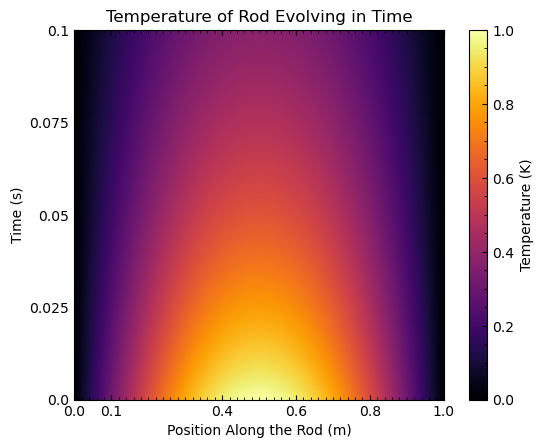

In [13]:
fig=plt.figure()
ax=fig.add_subplot(111)

img=ax.imshow(T, 'inferno')
ax.set_ylim(ax.get_ylim()[::-1]) #reverse order of y limits
cb=fig.colorbar(img)

#relabel axes from indexes to time and position. not generalized but makes the plot look nicer
ixs_x=np.array([0, 100, 400, 600, 800, 1000])
ixs_y=np.array([0, 250, 500, 750, 1000])
ax.set_xticks(ixs_x, ixs_x/1000)
ax.set_yticks(ixs_y, ixs_y/10000)

#label; guessing units based on what is standard/seems reasonable for the situation.
ax.set_xlabel('Position Along the Rod (m)')
ax.set_ylabel('Time (s)')
cb.set_label('Temperature (K)')
ax.set_title('Temperature of Rod Evolving in Time')

## Fixed End Temperature Case

As another example, let us consider the case where the rod starts at a constant temperature but with the ends held at fixed temperatures. We wish to see how the heat propagates from the ends of the rod in this case.

As a specific example we will consider $T(0,x)=100$ except at the end points where $T(0,0)=50$ and $T(0,1)=200$.

To keep these end points fixed we need to do a few things.
1. Go back to the matrix $\mathsf{A}$ from the prelab. We modify it by setting the first and last rows of this matrix to zero, then setting the diagonal elements to one, that is $A_{0,0}=A_{N-1,N-1}=1$. This will lead to small changes in how we construct the banded matrix `ab`.
2. We need to make similar changes on the right hand side of the equation. The easiest way to do this is to reuse what we did for the test case and then change the end points by hand. This means, calculate $\vec\tau_j$ as we did above, but then replace the first element in this vector with $T(0,0)$ and the last element with $T(0,1)$.

Finally, to obtain a numerically stable solution let $N_x=101$, $N_t=1001$, and $\Delta t=2\times 10^{-4}$.

Solve for the heat flow in the rod as function of time, $T(t,x)$, using the method described above. Provide the code for doing this below.

Retyping the $\mathsf{A}$ matrix in an effort to understand the changes:
$$ \mathsf{A} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 \\
-r & 1+2r & -r & 0 & 0 \\
0 & -r & 1+2r & -r & 0 \\
0 & 0 & -r & 1+2r & -r \\
0 & 0 & 0 & 0 & 1
\end{pmatrix}$$

In [14]:
#update coefficient matrix creation
def coefficient_matrix(N, r):
    """
    Construct the updated banded coefficient matrix (named A above) for the heat 
      equation. A is an NxN tridiagonal matrix based on the passed value r (the step 
      size used the Crank-Nicholson method to solve the heat equation) and returned as 
      a banded matrix which can be passed to  `scipy.linalg.solve_banded`.
    Inputs:
      N: integer: number of linear equations to solve
      r: float: step size parameter for the Crank-Nicolson method
    Outputs:
      ab: 2d array of size 3xN
    """
    diag = np.full(N, 1+2*r)
    diag[0]=1
    diag[-1]=1

    #construct upper diagonal
    upper = np.full(N, -r)
    upper[:2]=0 #set the first two indices, but notably the first recognized index, to 0 to reflect the new A matrix

    #construct the lower diagonal 
    lower=np.full(N, -r)
    lower[-2:]=0 #set the last two indices, but notably the last recognized index, to 0 to reflect the new A matrix 

    #construct and return the matrix
    A=np.array([upper, diag, lower])
    return A

#define given parameters 
segments=100
N=segments+1
L=1
del_x=L/segments
del_t=2e-4
start_temp=50
end_temp=200

#calculate r
r=del_t/(2*(del_x**2))

#create the array of initial temperatures along the rod, including end conditions
x=np.linspace(0,L,N)
init_T = np.full_like(x, 100)
init_T[0]=start_temp
init_T[-1]=end_temp

#create an array of times. done somewhat clunkily to be able to use linspace
#instead of arange, since linspace works better for the small numbers being used
#here.
end_time=.1
num=1001
times = np.linspace(0,end_time,num)

#create an array with as many rows as times being examined, where each row
#contains all the positions along the rod we are examining. fill the first
#row with the given initial condition, and iterate from there via finding 
#a new right side and A matrix and solving that system, setting the end
#conditions by hand each time. 
T=np.zeros((len(times), len(x)))
T[0]=init_T
for i in range(1,num):
    right_side=tau(T[i-1], r)
    right_side[0]=start_temp
    right_side[-1]=end_temp
    T[i]=la.solve_banded((1,1), coefficient_matrix(N, r), right_side)

Produce a nice figure of your results showing the temperature along the rod at the times, $t=0$, $0.025$, $0.05$, $0.075$, and $0.2$. This figure should make sense. In particular, after a long time what do you expect the temperature profile to look like?

Text(0.5, 1.0, 'Temperature vs Position of Rod Evolving in Time')

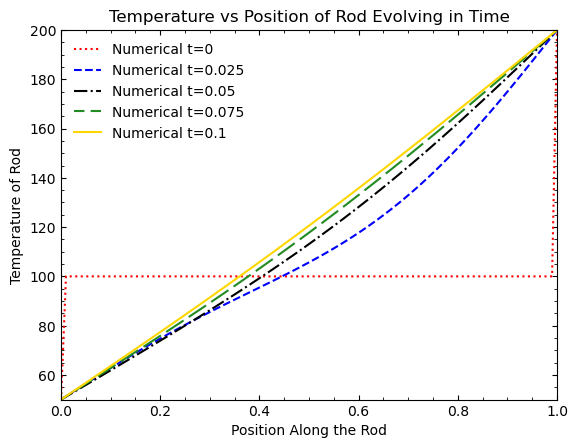

In [15]:
#times at which to plot the temperature, and colors and linestyles of the solutions at those times
plot_times=[0, .025, .05, .075, .1]
colors=['r', 'b', 'k', 'forestgreen', 'gold']
line=[':', '--', '-.', (5, (10, 3)), '-']
    
fig=plt.figure()
ax=fig.add_subplot(111)
def visual(i):
    '''
    Determine the array index of a given time, and plot the temperature at 
      that time against position.  
    Inputs: 
      i: int: an index of an array containing times to be plotted. 
    '''
    ix = np.where(times==plot_times[i])
    ax.plot(x, T[ix][0], c=colors[i], ls=line[i], label=f'Numerical t={plot_times[i]}')

visual(0)
visual(1)
visual(2)
visual(3)
visual(4)

ax.set_xlim(0,1)
ax.set_ylim(50, 200)
ax.legend(frameon=False)
ax.set_xlabel('Position Along the Rod')
ax.set_ylabel('Temperature of Rod')
ax.set_title('Temperature vs Position of Rod Evolving in Time')

We again want to produce a heat flow image using `imshow`. If we do this we find the resulting image is a thin rectangle since $N_x\ne N_t$. To get a square image we can use the keyword argument `aspect="auto"` to `imshow` which will automatically stretch the rectangle into a square. Otherwise the procedure is the same as that followed in the test case above.

Text(0.5, 1.0, 'Temperature of Rod Evolving in Time')

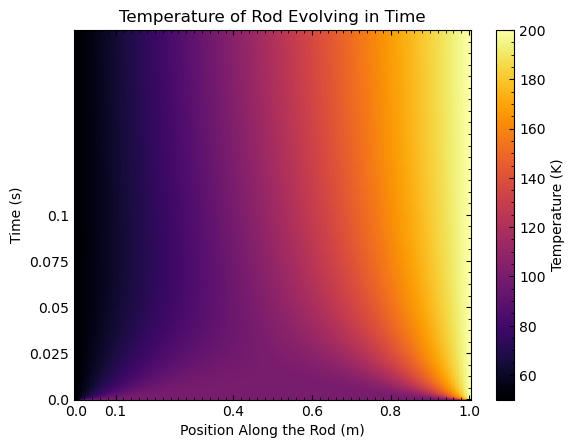

In [16]:
fig=plt.figure()
ax=fig.add_subplot(111)
img=ax.imshow(T, 'inferno', aspect='auto') #ensure the plot is square
ax.set_ylim(ax.get_ylim()[::-1]) #reverse order of y limit
cb=fig.colorbar(img)

#relabel axes from indexes to time and position. not generalized but makes the plot look nicer
ixs_x=np.array([0, 10, 40, 60, 80, 100])
ixs_y=np.array([0, 125, 250, 375, 500])
ax.set_xticks(ixs_x, ixs_x/100)
ax.set_yticks(ixs_y, ixs_y/5000)

#label; guessing units based on what is standard/seems reasonable for the situation.
ax.set_xlabel('Position Along the Rod (m)')
ax.set_ylabel('Time (s)')
cb.set_label('Temperature (K)')
ax.set_title('Temperature of Rod Evolving in Time')

## Member Participation

See Lab00 for instructions on turning in labs. We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who participated in this lab. Again, see Lab00 for more details. It is expected that you have read and understood those details.

skv34 vwf5 sgg64